# M3 Agentic AI - 将函数变成工具

## 1. 引言

### 1.1. 实验概览

在本次无评分实验中，你将使用 `aisuite` 创建一组工具并提供给 LLM。你将看到 LLM 如何请求使用工具，以及在任务相关时如何选择合适的工具。

### 🎯 1.2 学习目标

将工具调用的设计模式应用到智能体工作流。

为实现这一点，你将通过 AISuite 向 LLM 提供受控的 Python 函数访问能力，管理参数传递与执行流程，并验证通过工具编排生成的多步输出。


## 2. 环境设置：初始化环境与客户端

与之前实验一样，你将从初始化环境开始。现在导入若干包，并在后续构建工具时根据需要继续导入。

In [1]:
import json
import display_functions
from dotenv import load_dotenv
_ = load_dotenv()

### 2.1 开始使用 AISuite

接下来，初始化你在之前课程中见到的 **AISuite** 客户端。初始化后，它将作为你生成智能体响应与调用工具的接口。

运行下方单元以初始化客户端。

In [2]:
import aisuite as ai

# 创建 AISuite 客户端实例
client = ai.Client()

## 3. 构建你的第一个工具

### 3.1 定义你的函数

环境已就绪，现在该创建你的第一个工具了。运行下方单元，定义一个返回当前时间字符串的函数。注意该工具包含了函数用途的 docstring 说明，这对 `aisuite` 很重要，因为它会用这些信息帮助 LLM 了解该工具。

In [3]:
from datetime import datetime

def get_current_time():
    """
    返回当前时间的字符串。
    """
    return datetime.now().strftime("%H:%M:%S")

测试你的函数以查看其具体返回值。

<div style="background-color:#ffe4e1; padding:12px; border-radius:6px; color:black;">
  <strong>注意：</strong> DeepLearning.AI 平台默认使用格林尼治标准时间（GMT）。如果在本地运行，该函数将返回你的本地时间。
</div>

In [4]:
get_current_time()

'07:29:50'

很好！正如预期，该函数返回了你的当前时间字符串。

### 3.2 将函数变成 LLM 工具

现在我们用 `aisuite` 将该工具提供给 LLM 并获取响应。要设置你的工具，首先需要设置来自 LLM 的 `response`。创建响应前需先构建消息结构：包含用户的提示词，以及表示会话历史的字典，其中每条消息包含 `role`（例如 "user"、"assistant"、"system"）与 `content`。

In [5]:
# 消息结构
prompt = "现在几点？"
messages = [
    {
        "role": "user",
        "content": prompt,
    }
]

定义好消息结构后，你可以构建聊天补全（chat completion）。这将调用 LLM 并返回结果。我们来看一下该调用的参数：
* `model`：所用的模型
* `messages`：传递给 LLM 的消息列表
* `tools`：LLM 可使用的工具列表
* `max_turns`：允许 LLM 生成的最大消息数，有助于避免陷入无限循环并反复调用某个工具。

运行下方单元以调用 LLM 并查看响应。

In [6]:
response = client.chat.completions.create(
    model="openai:gpt-4o",
    messages=messages,
    tools=[get_current_time],
    max_turns=5
)

# 查看 LLM 的响应
print(response.choices[0].message.content)

当前时间是 07:29:50。


至此，你已让 LLM 获得了工具访问能力！`aisuite` 将你的函数转换为工具，增强了 LLM 关于世界的可用知识。

### 3.3 更深入地查看响应
虽然最终响应的内容符合预期，但 `response` 背后实际上发生了许多事情。我们使用一个有用的辅助函数来深入观察：`pretty_print_chat_completion` 会从响应中提取步骤，并以易读的格式展示关键部分。

In [7]:
display_functions.pretty_print_chat_completion(response)

如你所见，LLM 发送了一条消息请求使用 `get_current_time`。该调用在你的机器上执行后返回给 LLM。最终，LLM 基于完整的会话历史生成了最终回复。使用 `max_turns` 并向客户端传递函数名时，`aisuite` 负责从响应中提取工具调用消息、在本地执行并将结果回传给 LLM 的所有复杂细节。

### 3.4 手动定义工具

你已经看到工具的 docstring 可以帮助 `aisuite` 自动把函数变成 LLM 可用的工具。这非常方便。但在幕后究竟发生了什么，才能让你的函数被包装为工具？

实际上，LLM 所看到的工具结构更为复杂。下面我们看看 LLM *实际* 获得的工具是怎样的。与之前一样，工具通过列表传入；但列表中的每个工具都遵循一套约定的 schema。该 schema 包含几个关键部分：
* `name`：你在本地定义的对应函数名
* `description`：解释函数用途的描述，供 LLM 判断何时使用
* `parameters`：若函数有参数，这里也会描述参数名与参数含义

运行下方单元，依据该 schema 定义你的工具。

In [8]:
tools = [{
    "type": "function",
    "function": {
        "name": "get_current_time", # <--- 你的函数名
        "description": "返回当前时间的字符串。", # <--- 提供给 LLM 的描述
        "parameters": {}
    }
}]

在这种手动定义 schema 的场景下，`aisuite` 期望你自行处理执行流程。因此不会使用 `max_turns`，而是由你手动处理执行。我们先定义响应以完成设置。

In [9]:
response = client.chat.completions.create(
    model="openai:gpt-4o",
    messages=messages,
    tools=tools, # <-- 你的工具列表，包含 get_current_time
    # max_turns=5 # <-- 手动定义工具时需自行处理调用，不能使用 max_turns
)

现在可以查看来自 LLM 的响应。

In [10]:
print(json.dumps(response.model_dump(), indent=2, default=str))

{
  "id": "chatcmpl-CVeKC9Ev3yeykDPuNy5cs39VwUj8O",
  "choices": [
    {
      "finish_reason": "tool_calls",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": null,
        "refusal": null,
        "role": "assistant",
        "annotations": [],
        "audio": null,
        "function_call": null,
        "tool_calls": [
          {
            "id": "call_8Dg5JE961Lif5MwIZbUw7ypn",
            "function": {
              "arguments": "{}",
              "name": "get_current_time"
            },
            "type": "function"
          }
        ]
      }
    }
  ],
  "created": 1761659212,
  "model": "gpt-4o-2024-08-06",
  "object": "chat.completion",
  "service_tier": "default",
  "system_fingerprint": "fp_cbf1785567",
  "usage": {
    "completion_tokens": 11,
    "prompt_tokens": 45,
    "total_tokens": 56,
    "completion_tokens_details": {
      "accepted_prediction_tokens": 0,
      "audio_tokens": 0,
      "reasoning_tokens": 0,
      "rejected_pr

注意在 `response` 的 `message` 下可以看到 `tool_calls`。这表明 LLM 希望调用某个工具（此处为 `get_current_time`）。你可以添加一些逻辑来处理这一情况，然后将结果回传给模型并获得最终响应。

运行下方单元，在本地执行函数，返回结果给 LLM，并查看最终响应。

In [11]:
response2 = None

# 若响应对象中包含 tool_calls，则进入处理分支
if response.choices[0].message.tool_calls:
    # 从响应中提取具体的工具调用元数据
    tool_call = response.choices[0].message.tool_calls[0]
    args = json.loads(tool_call.function.arguments)

    # 在本地运行该工具
    tool_result = get_current_time()

    # 将工具结果追加到消息列表
    messages.append(response.choices[0].message)
    messages.append({
        "role": "tool", "tool_call_id": tool_call.id, "content": str(tool_result)
    })

    # 将包含新结果的消息列表回传给 LLM
    response2 = client.chat.completions.create(
        model="openai:gpt-4o",
        messages=messages,
        tools=tools,
    )

    print(response2.choices[0].message.content)


当前时间是 07:29:51。


至此，你实现了对 LLM 工具调用的手动处理。你可以选择通过 `max_turns` 让工具自动交给 LLM，或自行编写 schema 并手动处理中间步骤。

## 4. 为 LLM 提供更多工具

既然你已经了解了工具如何创建以及在本地如何处理，我们再创建几个新工具。

### 4.1 三个新工具

你将为 LLM 定义三个新工具：

- **Weather Tool (`get_weather_from_ip`)**
  通过外部 API 检测你的 IP 地址以获取地理位置，并调用天气 API 返回当前位置的当前温度、最高温与最低温。

- **File Writing Tool (`write_txt_file`)**
  在你的本地环境创建包含指定内容的文本文件。函数接收两个参数：`file_path` 与 `content`。

- **QR Code Generator (`generate_qr_code`)**
  根据数据生成二维码图像，可选嵌入中心图片。函数接收三个参数：`data`、`filename` 与 `img_path`。

运行下方单元以导入新包并定义这些工具。

In [12]:
import requests
import qrcode
from qrcode.image.styledpil import StyledPilImage


def get_weather_from_ip():
    """
    获取用户所在位置的当前、最高与最低温度（华氏制），并返回给用户。
    """
    # 通过 IP 地址获取地理坐标
    lat, lon = requests.get('https://ipinfo.io/json').json()['loc'].split(',')

    # 设置天气 API 调用的参数
    params = {
        "latitude": lat,
        "longitude": lon,
        "current": "temperature_2m",
        "daily": "temperature_2m_max,temperature_2m_min",
        "temperature_unit": "fahrenheit",
        "timezone": "auto"
    }

    # 获取天气数据
    weather_data = requests.get("https://api.open-meteo.com/v1/forecast", params=params).json()

    # 格式化并返回简洁字符串
    return (
        f"Current: {weather_data['current']['temperature_2m']}°F, "
        f"High: {weather_data['daily']['temperature_2m_max'][0]}°F, "
        f"Low: {weather_data['daily']['temperature_2m_min'][0]}°F"
    )

# 写入文本文件
def write_txt_file(file_path: str, content: str):
    """
    将字符串写入 .txt 文件（若已存在则覆盖）。
    参数：
        file_path (str)：目标路径。
        content (str)：要写入的文本。
    返回：
        str：写入文件的路径。
    """
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(content)
    return file_path


# 生成二维码
def generate_qr_code(data: str, filename: str, image_path: str):
    """给定数据与图片路径，生成二维码图像。

    参数：
        data：要编码的文本或 URL
        filename：输出 PNG 文件名（不含扩展名）
        image_path：用于嵌入到二维码中的图片路径
    """
    qr = qrcode.QRCode(error_correction=qrcode.constants.ERROR_CORRECT_H)
    qr.add_data(data)

    img = qr.make_image(image_factory=StyledPilImage, embedded_image_path=image_path)
    output_file = f"{filename}.png"
    img.save(output_file)

    return f"QR code saved as {output_file} containing: {data[:50]}..."

### 4.2 使用你的新工具

现在来使用这些新工具！`response` 的结构与之前类似，但不同的是你会把所有工具都传给 LLM。LLM 将基于你的提示选择合适的工具。我们先从 `get_weather_from_ip` 开始。


In [13]:
prompt = "可以帮我查询我所在位置的天气吗？"

response = client.chat.completions.create(
    model="openai:o4-mini",
    messages=[{"role": "user", "content": (
        prompt
    )}],
    tools=[
        get_current_time,
        get_weather_from_ip,
        write_txt_file,
        generate_qr_code
    ],
    max_turns=5
)

display_functions.pretty_print_chat_completion(response)

你可以看到，即使 LLM 拥有其他工具的访问权限，它也能根据提示意图选择正确的工具。

现在运行下方单元，提示 LLM 为你创建一条备忘。

In [14]:
prompt = "请帮我创建一个名为 reminders.txt 的备忘录，提醒我明天晚上7点给 Daniel 打电话。"

response = client.chat.completions.create(
    model="openai:o4-mini",
    messages=[{"role": "user", "content": (
        prompt
    )}],
    tools=[
        get_current_time,
        get_weather_from_ip,
        write_txt_file,
        generate_qr_code
    ],
    max_turns=5
)

display_functions.pretty_print_chat_completion(response)

现在你已经拥有包含提醒内容的文本文件了。可以看到 LLM 为工具传递了正确的参数，工具在本地运行，并返回了已完成操作的响应。你甚至可以打开该文本文件检查其内容以确认文件已生成。

In [15]:
with open('reminders.txt', 'r') as file:
    contents = file.read()
    print(contents)

明晚7点给 Daniel 打电话


最后，使用二维码生成工具创建一个跳转到 DeepLearning.AI 网站的二维码。

运行下方单元以生成该二维码。

In [16]:
prompt = "请用我公司的 logo 生成一个指向 www.deeplearning.ai 的二维码；logo 位于 `dl_logo.jpg`；文件名可命名为 dl_qr_code。"

response = client.chat.completions.create(
    model="openai:o4-mini",
    messages=[{"role": "user", "content": (
        prompt
    )}],
    tools=[
        get_current_time,
        get_weather_from_ip,
        write_txt_file,
        generate_qr_code
    ],
    max_turns=5
)

display_functions.pretty_print_chat_completion(response)

LLM 同样成功地将正确参数传给函数，随后使用这些信息运行函数并生成二维码。运行下方单元查看二维码，并试试是否能跳转到 DeepLearning.AI 网站。

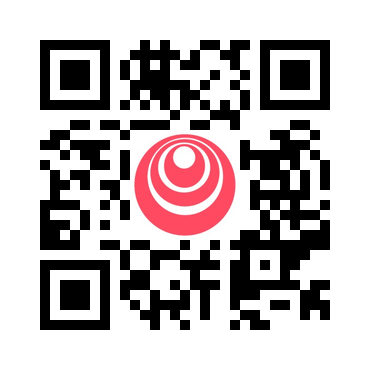

In [17]:
from IPython.display import Image, display

# Display image directly
Image('dl_qr_code.png')

### 4.3 同时使用多个工具

最后需要记住的是，LLM 可以按序列使用多个工具来完成多项任务。我们使用这些工具并查看 `response`，观察发生了什么。你将使用一个较复杂的提示：

> 你能帮我用图片 dl_logo.jpg 生成一个跳转到 www.deeplearning.com 的二维码吗？另外请写一个包含当前天气的 txt 备忘。

该提示需要一定的逻辑来决定何时调用哪些工具。例如，尽管你让它先写文本备忘并随后描述其内容，但 LLM 需要先获取天气信息才能写入备忘。如果它先调用 `write_txt_file`，则还没有来自 `get_weather_from_ip` 的信息。这个例子很好地展示了 LLM 解析自然语言并按正确顺序使用合适工具以完成多样任务的能力。

<div style="background-color: #ffe4e1; padding: 12px; border-radius: 6px; color: black;">

<h4>🔍 注意要点：</h4>

<ul>
  <li>LLM 会根据用户请求<b>自动选择</b>合适的工具</li>
  <li>从用户消息中<b>自动推断参数</b>（如文件名、内容、URL）</li>
  <li>每个工具<b>返回信息</b>并被 LLM 纳入其最终响应</li>
  <li><b>无参数工具</b>（如天气与时间）非常适合快速信息查询</li>
  <li>尽管幕后有复杂操作，对话依然<b>自然</b></li>
</ul>

</div>

In [18]:
prompt = "能否帮我用图片 dl_logo.jpg 生成一个跳转到 www.deeplearning.com 的二维码？另外再写一个包含当前天气的 txt 备忘。"

response = client.chat.completions.create(
    model="openai:o4-mini",
    messages=[{"role": "user", "content": (
        prompt
    )}],
    tools=[
        get_weather_from_ip,
        get_current_time,
        write_txt_file,
        generate_qr_code
    ],
    max_turns=10
)

display_functions.pretty_print_chat_completion(response)

可以从工具调用序列中看到，智能体按正确顺序调用了工具以完成任务，同时以你要求的顺序进行响应。

### 模型选项

在运行这些工具调用工作流时，你可以尝试不同的 OpenAI 模型。不同模型在能力、成本与速度之间提供不同平衡：

- **`openai:gpt-4o`** — 优化了推理与速度
- **`openai:gpt-4.1`** — 强推理性能，适合复杂任务
- **`openai:gpt-4.1-mini`** — 比完整 GPT-4.1 更轻、更快、且更便宜
- **`openai:gpt-3.5-turbo`** — 适合更简单任务与快速迭代

模型选择取决于你的目标：
- 小模型适合快速、低成本的原型开发
- 当任务需要更强推理或多步编排时，切换到更强的模型


### 关键收获

- 工具调用让 LLM 超越纯文本生成——它们可把函数作为推理的一部分。
- 清晰且文档完备的函数（精确的 docstring）有助于模型判断何时、如何使用工具。
- AISuite 负责将 Python 函数转换为工具 schema 并编排多步工作流的复杂性。
- 选择合适模型很重要：小模型在简单任务上更快更便宜，强模型更适合重推理的工作流。
- 观察完整的会话流程（提示、工具调用、结果、最终响应）对于调试与改进智能体行为至关重要。

理解以上要素后，你已具备将 LLM 推理与外部工具结合以完成更复杂任务的基础。


<div style="border:1px solid #22c55e; border-left:6px solid #16a34a; background:#dcfce7; border-radius:6px; padding:14px 16px; color:#064e3b; font-family:system-ui,-apple-system,Segoe UI,Roboto,Ubuntu,Cantarell,Noto Sans,sans-serif;">

🎉 <strong>恭喜！</strong>

你已经完成了使用 AISuite 将**函数变成工具**的实验。
在此过程中，<strong>你</strong>将 Python 函数暴露为工具，允许 LLM 选择并调用它们，并检查了多步工具编排。

具备这些技能后，<strong>你</strong>可以设计将 LLM 推理与实际动作结合的智能体工作流——可靠、可审计且易扩展。🌟

</div>
